# Demo of U-Net-based hiding network

In [2]:
import os.path

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
from torchvision import transforms

from hidden.models import UNetHidingNetwork, HiddenDecoder
from hidden.ops.transforms import Normalize, Denormalize

C:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Build models and load weights

The watermark signal can be rescaled with a factor `scaling_w`.

We use the just noticeable difference (JND) heatmap presented in https://github.com/facebookresearch/active_indexing to mask the watermark signal in areas where the eye is sensitive to changes.
This allows to impose perceptual constraint, in case we want to use the trained encoder to watermark images.

In [3]:
from argparse import Namespace

NORMALIZE = Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
DENORMALIZE = Denormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
default_transform = transforms.Compose([transforms.ToTensor(), NORMALIZE])

params = Namespace(
    img_channels=3, num_bits=48,
    decoder_depth=8, decoder_channels=64,
    device='cuda',
)
params.device = torch.device(params.device)

decoder = HiddenDecoder(
    num_blocks=params.decoder_depth,
    num_bits=params.num_bits,
    channels=params.decoder_channels,
    in_channels=params.img_channels,
)
encoder = UNetHidingNetwork(
    num_bits=params.num_bits,
    in_channels=params.img_channels,
    features_level_insertion=False,
)

In [4]:
project_root = os.path.dirname(os.path.dirname(os.path.abspath('')))
ckpt_path = os.path.join(project_root, 'hidden/outputs/cifar10_test/checkpoint.pth')

# load_state_dict
state_dict = torch.load(ckpt_path, weights_only=False, map_location='cpu')['encoder_decoder']
encoder_decoder_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
encoder_state_dict = {k.replace('encoder.', ''): v for k, v in encoder_decoder_state_dict.items() if 'encoder' in k}
decoder_state_dict = {k.replace('decoder.', ''): v for k, v in encoder_decoder_state_dict.items() if 'decoder' in k}

encoder.load_state_dict(encoder_state_dict)
decoder.load_state_dict(decoder_state_dict)

decoder = decoder.to(params.device).eval()
encoder = encoder.to(params.device).eval()

### Load Images

In [28]:
from torchvision.datasets import CIFAR10

dataset = CIFAR10(root=os.path.join(project_root, 'data'),
                  train=False, download=False, transform=default_transform)
print(f'Dataset size: {len(dataset)}')

to_img = transforms.Compose([
    DENORMALIZE,
    transforms.Lambda(lambda x: x.detach().cpu().squeeze(0)),
    transforms.ToPILImage(),
])

Dataset size: 10000


Loading image 3449


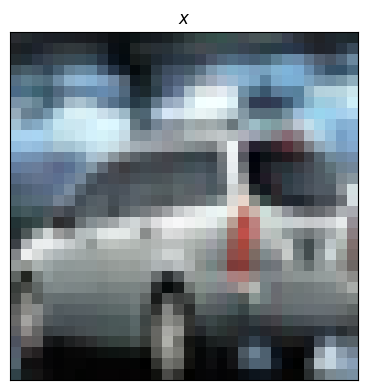

In [29]:
# load random image
id = torch.randint(0, len(dataset), (1,)).item()
print(f'Loading image {id}')
x = dataset[id][0].unsqueeze(0)
img = to_img(x)

# visualize
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(np.asarray(img), vmin=0, vmax=255)
ax.grid('off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('$x$')

fig.tight_layout()
plt.show()

### Tests

In [8]:
def msg2str(m: torch.Tensor) -> str:
    return ''.join([('1' if el else '0') for el in m.detach().cpu().bool()])


def str2msg(m_str: str, device=None) -> torch.Tensor:
    return torch.tensor([True if el == '1' else False for el in m_str], device=device)

Image 1850 - 1
PSNR: 35.64264
Message: 011101000110110001101001010111100001001000000000
Decoded: 111111001111110001001100000111110001001000001101
Bit Accuracy: 0.75000


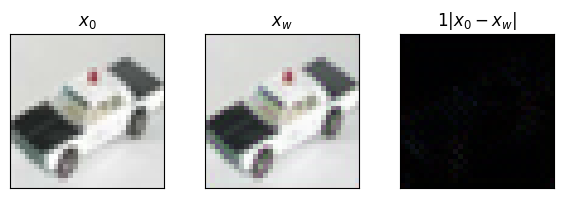

In [57]:
# load random image
id = torch.randint(0, len(dataset), (1,)).item()
x0, y = dataset[id]
x0 = x0.unsqueeze(0).to(params.device)
print(f'Image {id} - {y}')
img = to_img(x0)

# create message
random_msg = True
if random_msg:
    m = torch.bernoulli(torch.full((x0.size(0), params.num_bits), 0.5, device=params.device)).bool()  # b k
else:
    m = str2msg('1110101101010001', device=params.device).unsqueeze(0)
# cast to -1/1
m_normalized = 2 * m.to(torch.float) - 1  # b k

# encode
x_w = encoder(x0, m_normalized)
# img_w = to_img(torch.round(255 * torch.clamp(DENORMALIZE_MNIST(x_w), 0, 1)) / 255)
img_w = Image.fromarray(
    DENORMALIZE(x_w.squeeze(0)).squeeze().mul(255).clamp_(0, 255).permute((1, 2, 0)).to('cpu', torch.uint8).numpy(),
    mode='RGB')

# psnr
psnr = peak_signal_noise_ratio(np.asarray(img), np.asarray(img_w))
print(f'PSNR: {psnr:.05f}')

# decode
m_hat = decoder(x_w)
ori_msgs = torch.sign(m) > 0
decoded_msgs = torch.sign(m_hat) > 0  # b k -> b k
print(f'Message: {msg2str(ori_msgs.squeeze(0))}')
print(f'Decoded: {msg2str(decoded_msgs.squeeze(0))}')
print(f'Bit Accuracy: {torch.eq(ori_msgs, decoded_msgs).sum().item() / params.num_bits:.05f}')

# visualize
fig, axes = plt.subplots(1, 3, figsize=(6, 2))
axes = axes.flatten()
axes[0].imshow(np.asarray(img), vmin=0, vmax=255)
axes[0].grid('off')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('$x_0$')

axes[1].imshow(np.asarray(img_w), vmin=0, vmax=255)
axes[1].grid('off')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('$x_w$')

magnitude = 1
diff_img = np.abs(np.asarray(img).astype(int) - np.asarray(img_w).astype(int)) * magnitude
diff_img = np.clip(diff_img, 0, 255).astype(np.uint8)
axes[2].imshow(diff_img, vmin=0, vmax=255)
axes[2].grid('off')
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title(f'${magnitude}|x_0 - x_w|$')

fig.tight_layout()
plt.show()